# Image Segmentation using the idr0021 dataset

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ome/omero-guide-python/blob/master/notebooks/idr0021_segmentation.ipynb)

This notebook uses the idr0021 dataset [idr0021-lawo-pericentriolarmaterial/experimentA](https://idr.openmicroscopy.org/webclient/?show=project-51) and tries to reproduce some of the analysis published in ['Subdiffraction imaging of centrosomes reveals higher-order organizational features of pericentriolar material']((https://doi.org/10.1038/ncb2591); in particular to create a figure similar to [Figure 1](https://www.nature.com/articles/ncb2591/figures/1)  of the article.

### Install dependencies if required
The cell below will install dependencies if you choose to run the notebook in [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true).

In [2]:
# Ice Python binding
%pip install https://github.com/glencoesoftware/zeroc-ice-py-linux-x86_64/releases/download/20240202/zeroc_ice-3.6.5-cp310-cp310-manylinux_2_28_x86_64.whl
# Package required to interact with IDR or OMERO
%pip install omero-py==5.19.2

In [1]:
from IPython import get_ipython
from ipywidgets import *

from omero.gateway import BlitzGateway
import matplotlib.pyplot as plt
import pandas as pd


from skimage import filters
from skimage.morphology import closing, square
from skimage import measure

### Create a connection to IDR

In [3]:
HOST = 'ws://idr.openmicroscopy.org/omero-ws'
conn = BlitzGateway('public', 'public',
                    host=HOST, secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

True


### IDR image to analyze

In [4]:
image_id = 1884839

### Load image and display the second channel of the first z-section and timepoint

In [5]:
image = conn.getObject("Image", image_id)

(-0.5, 255.5, 255.5, -0.5)

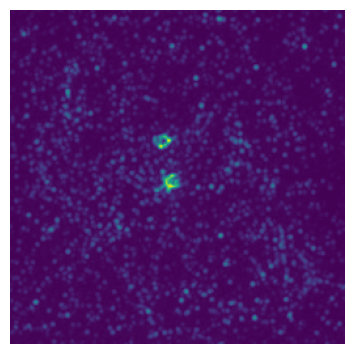

In [6]:
get_ipython().run_line_magic('matplotlib', 'inline')
pixels = image.getPrimaryPixels()
channels = image.getChannels()
plt.figure(figsize=(25, 20))
plt.subplot(1, 5, 1)
image_plane = pixels.getPlane(0, 1, 0)
plt.imshow(image_plane)
plt.axis('off')

### Segment the plane and overlay the labels

You can use the slider to change the thresholding value

In [7]:
def segment(v=5):
    # denoising
    blurred = filters.median(image_plane)
    # binarization
    threshold = filters.threshold_otsu(blurred)
    binary = closing(blurred <= threshold, square(v))
    label_image = measure.label(binary, background=1)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_plane)
    ax.contour(label_image, [0.5], linewidths=1.2, colors='r')
    plt.show()
    return label_image

output = interactive(segment, image_plane=image_plane, v= widgets.IntSlider(value=5, min=0, max=10, step=1, description="Threshold", continuous_update=False))
display(output)


interactive(children=(IntSlider(value=5, continuous_update=False, description='Threshold', max=10), Output()),…

### Calculate statistics for the regions 

In [8]:
label_image = output.result
properties = measure.regionprops(label_image, intensity_image=image_plane)

In [9]:
statistics = {
    'area':       [p.area               for p in properties],
    'mean':       [p.mean_intensity     for p in properties],
    'major_axis': [p.major_axis_length  for p in properties],
    'perimeter' : [p.perimeter          for p in properties],
    'orientation' :  [p.orientation          for p in properties],
    'eccentricity':  [p.eccentricity          for p in properties],
    'centroid':  [p.centroid          for p in properties],
}

### Print out the statistics
Save the output as CSV file in the home directory. To download the CSV file, go to ``File > Open...``. Select the CSV file and click the ``Download`` button.

In [10]:
dataframe = pd.DataFrame(statistics)
dataframe.to_csv('output_%s.csv' % image_id)
dataframe

,area,mean,major_axis,perimeter,orientation,eccentricity,centroid
0,25.0,4079.601807,5.656854,16.000000,-0.785398,0.000000,"(7.0, 160.0)"
1,63.0,2387.954102,12.282460,28.828427,1.545926,0.842281,"(46.38095238095238, 47.06349206349206)"
2,30.0,3937.480469,6.831301,18.000000,0.000000,0.560612,"(64.5, 44.0)"
3,30.0,3056.841309,6.831301,18.000000,0.000000,0.560612,"(80.5, 44.0)"
4,178.0,5610.624023,19.284840,53.556349,-1.413647,0.773806,"(100.03932584269663, 117.13483146067416)"
5,46.0,3208.973145,8.953485,22.828427,1.402459,0.678009,"(100.5, 173.5)"
6,30.0,2140.024902,6.831301,18.000000,0.000000,0.560612,"(121.5, 24.0)"
7,283.0,5693.296387,23.445249,73.556349,-0.884001,0.687933,"(132.73498233215548, 120.41342756183745)"
8,35.0,2951.628662,8.000000,20.000000,0.000000,0.707107,"(168.0, 83.0)"
9,40.0,2745.622559,9.165151,22.000000,0.000000,0.786796,"(178.5, 207.0)"


### Close the connection 

In [11]:
conn.close()

### License (BSD 2-Clause)
Copyright (C) 2022-2024 University of Dundee. All Rights Reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. 